<h1 style='color:purple' align='center'> Regression Project: Predicting Home Prices</h1>

In [70]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)

<h2 style='color:green'>Data Load: Load banglore home prices into a dataframe</h2>

In [71]:
df1=pd.read_csv("bengaluru_house_prices.csv")
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [72]:
df1.shape

(13320, 9)

In [73]:

df1.groupby('area_type')['area_type'].agg('count')

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

In [74]:
df2=df1.drop(['area_type','availability','society','balcony'],axis='columns')
df2.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


<h2 style='color:green'>Data Cleaning: Handle NA values</h2>

In [75]:
df2.isna().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [76]:
df3=df2.dropna()
df3.isna().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [77]:
df3.shape

(13246, 5)

In [78]:
df3['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [79]:
df3['bhk']=df3['size'].apply(lambda x : int(x.split(' ')[0]))

In [80]:
df3.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [81]:
df3['bhk'].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

In [82]:
df3[df3.bhk>20]

,location,size,total_sqft,bath,price,bhk
1718,2Electronic City Phase II,27 BHK,8000,27.0,230.0,27
4684,Munnekollal,43 Bedroom,2400,40.0,660.0,43


In [83]:
df3.total_sqft.unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [84]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True    
        

In [85]:
df3[~df3['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


In [86]:
def convert_sqft_to_num(x):
    tokens=x.split('-')
    if len(tokens)==2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None
    

In [87]:
convert_sqft_to_num('3389')

3389.0

In [88]:
convert_sqft_to_num('1145 - 1340')

1242.5

In [89]:
convert_sqft_to_num('34.46Sq. Meter')

In [90]:
df4=df3.copy()
df4['total_sqft']=df3['total_sqft'].apply(convert_sqft_to_num)
df4.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


In [91]:
df5=df4.copy()
df5['price_per_sqft']=df5['price']*100000/df5['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [92]:
len(df5.location.unique())

1304

In [93]:
df5.location=df5.location.apply(lambda x : x.strip())
location_stats=df5.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_stats

location
Whitefield               535
Sarjapur  Road           392
Electronic City          304
Kanakpura Road           266
Thanisandra              236
                        ... 
1 Giri Nagar               1
Kanakapura Road,           1
Kanakapura main  Road      1
Karnataka Shabarimala      1
whitefiled                 1
Name: location, Length: 1293, dtype: int64

In [94]:
len(location_stats[location_stats<=10])

1052

<h2 style="color:green">Dimensionality Reduction</h2>

In [95]:
location_stats_less_then_10=location_stats[location_stats<=10]
location_stats_less_then_10

location
Basapura                 10
1st Block Koramangala    10
Gunjur Palya             10
Kalkere                  10
Sector 1 HSR Layout      10
                         ..
1 Giri Nagar              1
Kanakapura Road,          1
Kanakapura main  Road     1
Karnataka Shabarimala     1
whitefiled                1
Name: location, Length: 1052, dtype: int64

In [96]:
len(df5.location.unique())

1293

In [97]:
df5.location=df5.location.apply(lambda x: 'other' if x in location_stats_less_then_10 else x)
len(df5.location.unique())

242

In [98]:
df5.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


In [99]:
df5[df5.total_sqft/df5.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


In [100]:
df5.shape

(13246, 7)

<h2 style="color:green">Outlier Removal Using Business Logic</h2>

In [101]:
df6=df5[~(df5.total_sqft/df5.bhk<300)]

In [102]:
df6.shape

(12502, 7)

In [103]:
df6.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

In [104]:
def remove_pps_outlier(df):
    df_out=pd.DataFrame()
    for key , subdf in df.groupby('location'):
        m=np.mean(subdf.price_per_sqft)
        st=np.std(subdf.price_per_sqft)
        reduced_df=subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out=pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df7=remove_pps_outlier(df6)
df7.shape

(10241, 7)

<h3 style='color:green'>Before outlier removal: Hebbal</h3>

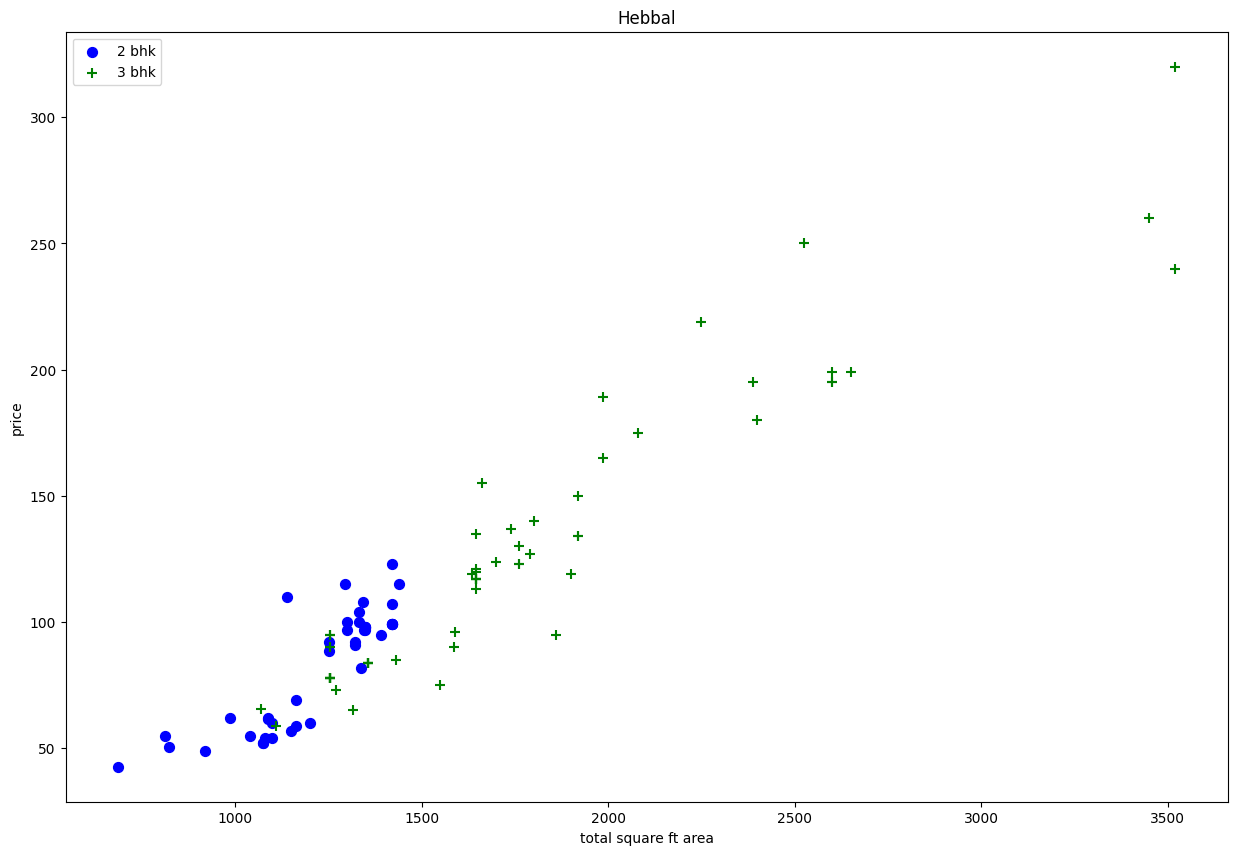

In [105]:
def plot_scatter_chart(df,location):
    bhk2=df[(df.location==location) & (df.bhk==2)]
    bhk3=df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize']=(15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 bhk',s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+',color='green',label='3 bhk',s=50)
    plt.xlabel('total square ft area')
    plt.ylabel('price')
    plt.title(location)
    plt.legend()
plot_scatter_chart(df7,'Hebbal')    

In [106]:
def remove_bhk_outliers(df):
    exclude_indices=np.array([])
    for location,location_df in df.groupby('location'):
        bhk_stats={}
        for bhk,bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk]={
                'mean':np.mean(bhk_df.price_per_sqft),
                'std':np.std(bhk_df.price_per_sqft),
                'count':bhk_df.shape[0]
            } 
        for bhk,bhk_df in location_df.groupby('bhk'):
            stats=bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices=np.append(exclude_indices,bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index') 

In [107]:
df8=remove_bhk_outliers(df7)
df8.shape

(7329, 7)

<h3 style='color:green'>after outlier removal: Hebbal</h3>

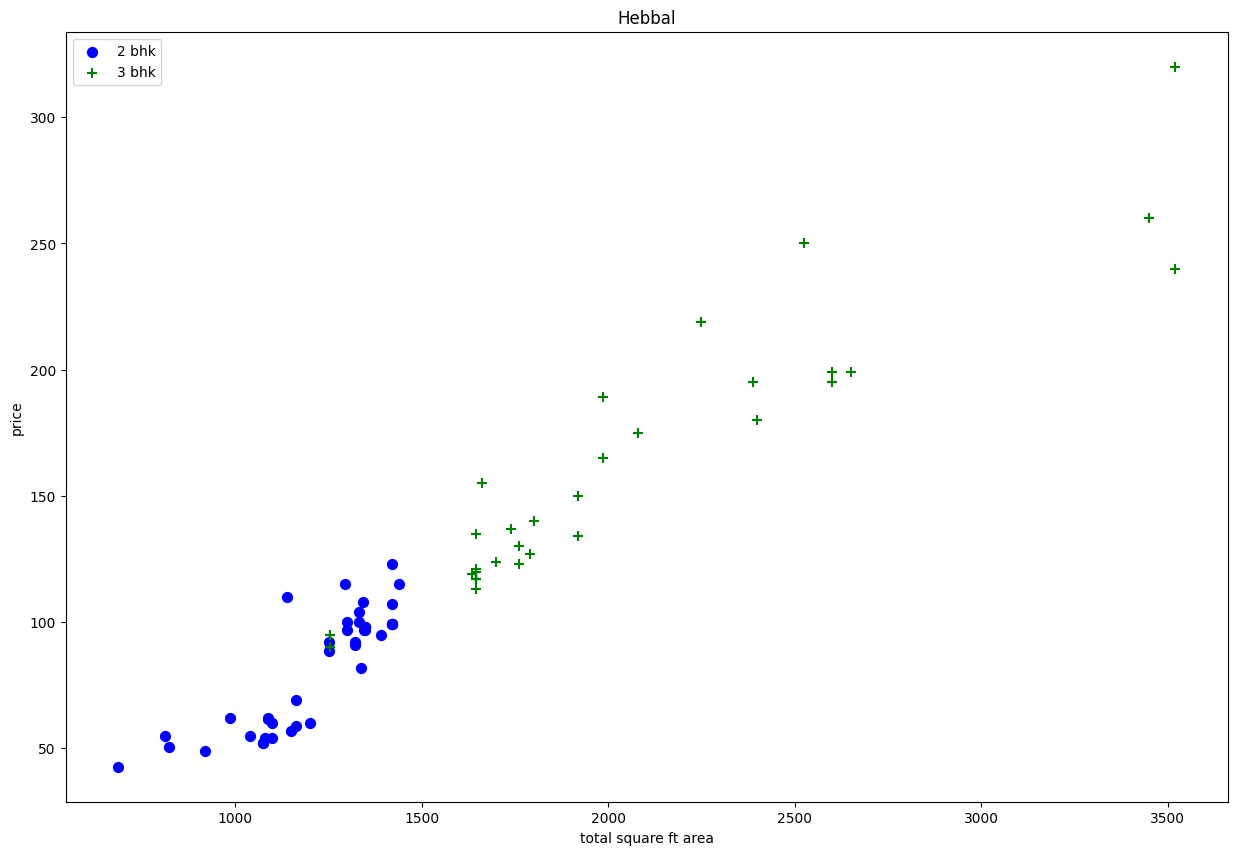

In [108]:
plot_scatter_chart(df8,'Hebbal')

Text(0, 0.5, 'count')

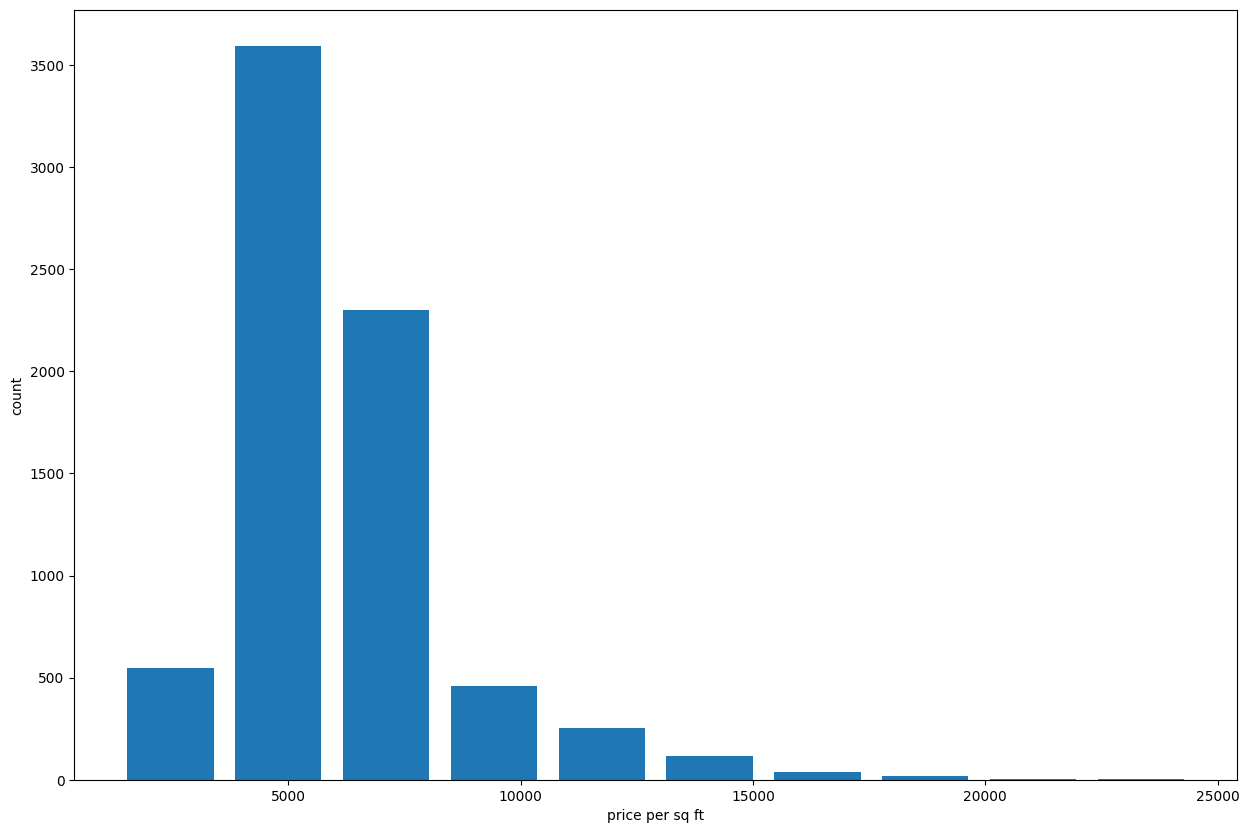

In [109]:
plt.hist(df8.price_per_sqft,rwidth=0.8)
plt.xlabel('price per sq ft')
plt.ylabel('count')

In [110]:
df8.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

<h2 style='color:green'>Outlier Removal Using Bathrooms Feature</h2>

In [111]:
df8[df8.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5277,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8486,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8575,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9308,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9639,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


Text(0, 0.5, 'count')

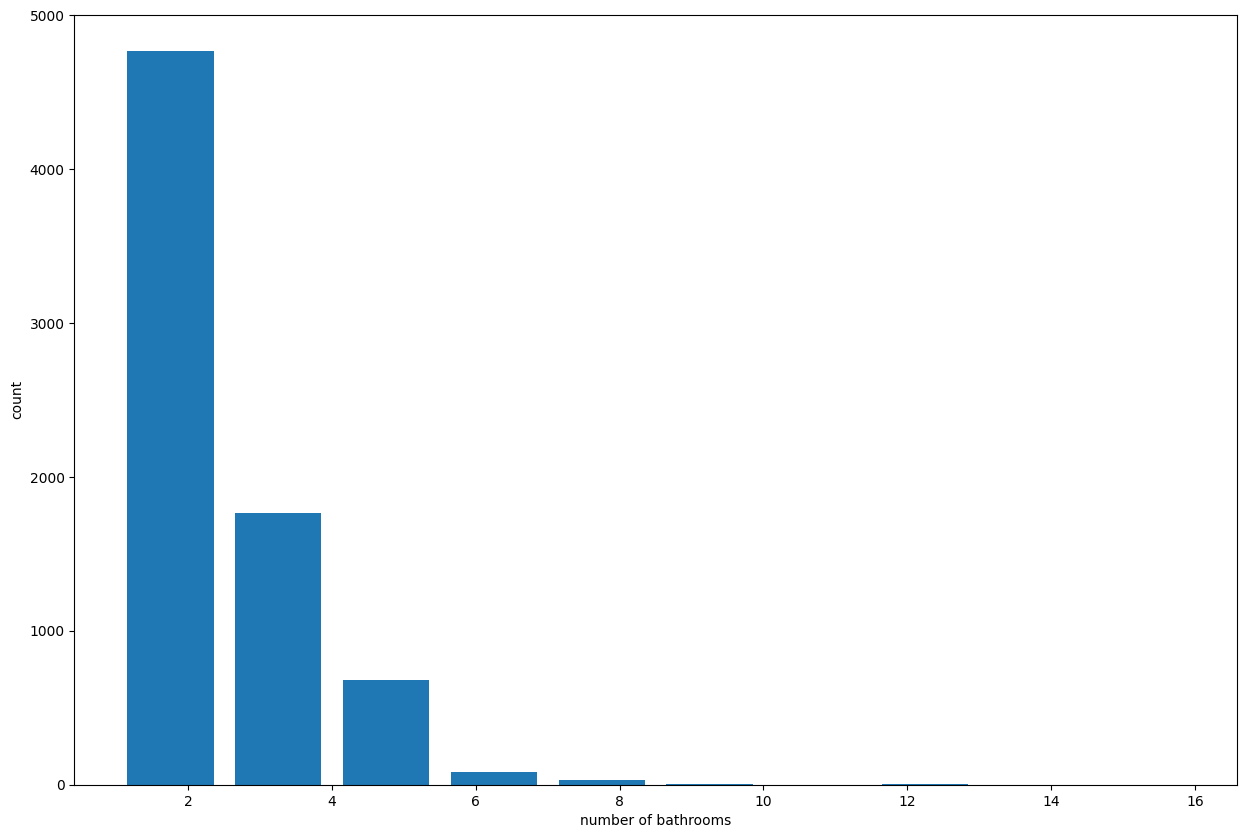

In [112]:
plt.hist(df8.bath,rwidth=0.8)
plt.xlabel('number of bathrooms')
plt.ylabel('count')

In [113]:
df8[df8.bath>df8.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1626,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5238,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6711,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8411,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


In [114]:
df9=df8[df8.bath<df8.bhk+2]
df9.shape

(7251, 7)

In [115]:
df10=df9.drop(['size','price_per_sqft'],axis='columns')
df10.head()

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2


<h2 style='color:green'>Use One Hot Encoding For Location</h2>

In [116]:
dummies=pd.get_dummies(df10.location)
dummies.head()

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [117]:
df11=pd.concat([df10,dummies.drop('other',axis='columns')],axis='columns')
df11.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1st Block Jayanagar,1630.0,3.0,194.0,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1st Block Jayanagar,1875.0,2.0,235.0,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1st Block Jayanagar,1200.0,2.0,130.0,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1st Block Jayanagar,1235.0,2.0,148.0,2,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [118]:
df12=df11.drop('location',axis='columns')
df12.head()

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1630.0,3.0,194.0,3,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1875.0,2.0,235.0,3,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1200.0,2.0,130.0,3,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1235.0,2.0,148.0,2,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [119]:
df12.shape

(7251, 245)

<h2 style='color:green'>Build a Model Now...</h2>

In [120]:
x=df12.drop('price',axis='columns')
x.head()

,total_sqft,bath,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1630.0,3.0,3,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1875.0,2.0,3,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1200.0,2.0,3,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1235.0,2.0,2,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [121]:
y=df12.price
y.head()

0    428.0
1    194.0
2    235.0
3    130.0
4    148.0
Name: price, dtype: float64

In [122]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=10)

In [123]:
from sklearn.linear_model import LinearRegression
lr_clf=LinearRegression()
lr_clf.fit(x_train,y_train)
lr_clf.score(x_test,y_test)

0.8452277697874357

In [124]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
cv=ShuffleSplit(n_splits=5,test_size=0.2,random_state=0)
cross_val_score(LinearRegression(),x,y,cv=cv)

array([0.82430186, 0.77166234, 0.85089567, 0.80837764, 0.83653286])

<h2 style='color:green'>Find best model using GridSearchCV</h2>

In [125]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(x,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'fit_intercept': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(x,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(x,y)

,model,best_score,best_params
0,linear_regression,0.819001,{'fit_intercept': False}
1,lasso,0.687433,"{'alpha': 2, 'selection': 'random'}"
2,decision_tree,0.720157,"{'criterion': 'friedman_mse', 'splitter': 'best'}"


<h2 style='color:green'>Test the model for few properties</h2>

In [126]:
def predict_price(location,sqft,bath,bhk):    
    loc_index = np.where(x.columns==location)[0][0]

    X = np.zeros(len(x.columns))
    X[0] = sqft
    X[1] = bath
    X[2] = bhk
    if loc_index >= 0:
        X[loc_index] = 1

    return lr_clf.predict([X])[0]

In [127]:
x.columns

Index(['total_sqft', 'bath', 'bhk', '1st Block Jayanagar',
       '1st Phase JP Nagar', '2nd Phase Judicial Layout',
       '2nd Stage Nagarbhavi', '5th Block Hbr Layout', '5th Phase JP Nagar',
       '6th Phase JP Nagar',
       ...
       'Vijayanagar', 'Vishveshwarya Layout', 'Vishwapriya Layout',
       'Vittasandra', 'Whitefield', 'Yelachenahalli', 'Yelahanka',
       'Yelahanka New Town', 'Yelenahalli', 'Yeshwanthpur'],
      dtype='object', length=244)

In [128]:
predict_price('1st Phase JP Nagar',1000,2,2)

83.49904677198772

In [129]:
predict_price('1st Phase JP Nagar',1000,3,3)

86.80519395225497

In [130]:
predict_price('Indira Nagar',1000,2,2)

181.27815484006513

In [131]:
predict_price('Indira Nagar',1000,3,3)

184.58430202033236

<h2 style='color:green'>Export the tested model to a pickle file</h2>

In [132]:
import pickle
with open('banlore_home_price_final_model.pickle','wb') as f:
    pickle.dump(lr_clf,f)

In [133]:
import json
columns = {
    'data_columns' : [col.lower() for col in x.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))